# definitely not production code

hashtags: #edit #kill #todo #note #float32 #new #del 1/0

debug vars: SEE DEBUG TEST PROD BUG

In [1]:
# from common import *
# from pandas.api.types import CategoricalDtype
# import warnings 
# warnings.filterwarnings('ignore')
# %matplotlib inline
# canvas(12,12)

In [2]:
# ho_time = pd.Timestamp('2015-07-01',tz='UTC')

# def fake(*,M,N):
#     M_, N_ = M, N
#     for time, M in M_.groupby('time'):
#         if time<ho_time:
#             continue
#         M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
#         P = M[excluded_columns]
#         M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
#         P['confidenceValue'] = 0.
#         yield M, None, P

In [3]:
#from common import *

### important devops code

In [4]:
TEST = False

# #################################################### START HERE

In [5]:
import pandas as pd
M = pd.read_pickle('../data/given/M.pkl')
N = None #pd.read_pickle('../data/given/N.pkl')
#test = pd.read_pickle('../data/given/test.pkl')

In [6]:
class __env__():
    _submitted = []
    # -1 = begin, 0 = just yielded, 1 = just predicted, -2 = finished, -3 = finished and submission file written too
    _states = [-1]
    
    class KaggleEnvError(Exception):
        pass
    
    @staticmethod
    def get_training_data():
        global N
        try:
            return M, N
        except NameError:
            return M, None
    
    @staticmethod
    def get_prediction_days():
        env = __class__
        
        class iter_get_prediction_days():
            def __iter__(self):
                if env._states[-1] != -1:
                    raise env.KaggleEnvError('can only call get_prediction_days once!')
                
                env._days_iter = test.__iter__()
                return self
            
            def __next__(self):
                if env._states[-1] == 0:
                    raise env.KaggleEnvError('can only yield next day after the previous day was submitted')
                elif env._states[-1] not in [-1, 1, -2, -3]:
                    raise env.KaggleEnvError(
                        'environment internal error [bad state {} for __next__]'.format(env._states[-1]))
                
                try:
                    ret = env._days_iter.__next__()
                except StopIteration:
                    if env._states[-1] not in [-2, -3]:
                        env._states.append(-2)
                    raise
                
                env._states.append(0)
                return ret
        
        return iter_get_prediction_days()
            
    @staticmethod
    def predict(p):
        env = __class__
        if env._states[-1] == 1:
            raise env.KaggleEnvError('must get next prediction day before submitting a prediction again')
        elif env._states[-1] == -1:
            raise env.KaggleEnvError('must get next prediction day before submitting a prediction')
        elif env._states[-1] in [-2, -3]:
            raise env.KaggleEnvError('cannot submit prediction, every prediction has already been submitted')
        elif env._states[-1] != 0:
            raise env.KaggleEnvError('environment internal error [bad state {}]'.format(env._states[-1]))
        env._submitted.append(p)
        env._states.append(1)
        
    @staticmethod
    def write_submission_file():
        env = __class__
        if env._states[-1] not in [-2, -3]:
            raise env.KaggleEnvError('must be finished predicting before writing submission file')
            
        template = pd.concat((day[2] for day in test), axis=0)
        try:
            submission = pd.concat((sub for sub in env._submitted), axis=0)
            assert (template.shape==submission.shape), 'submissions have malformed shape'
            assert (template.index==submission.index).all(), 'submissions have malformed index'
            assert (template.columns==submission.columns).all(), 'submissions have malformed columns'
            assert (template.assetCode==submission.assetCode).all(), 'submissions have malformed assetCode column'
        except Exception as e:
            raise env.KaggleEnvError(e)
        
        env._submission = submission
        if env._states[-1] != -3:
            env._states.append(-3)
        print('''Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, '''+
                '''you can submit the file to the competition from the Kernel Viewer `Output` tab.''')

# +++++++++++++++++++++ production additions ++++++++++++++++++++++

### imports

In [7]:
import numpy as np
import pandas as pd

import random, math, functools, itertools, os, gc
from collections import Counter, namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import altair as alt
#from altair import *
#sns.set()
plt.style.use(['classic', 'seaborn', 'seaborn-colorblind'])

def canvas(width, height):
    dpi = 96
    from pylab import rcParams
    rcParams['figure.figsize'] = width, height
    
import lightgbm as lgb
import numba
from numba import njit #EDITCELL

### `utility.py`

In [8]:
from itertools import chain
from importlib import reload
from functools import wraps, reduce, lru_cache
memoized = lru_cache(maxsize=-1, typed=False)

### `object.py`

In [9]:
import collections

def _mydict_init_items_(*args, **kwargs):
    items = ()
    if len(args) == 3:
        space = args[2]
        for k in list(space.keys()):
            if str.startswith(k, '__') and str.endswith(k, '__'):
                del space[k]
        items = space.items()
    elif args and isinstance(args[0], collections.Mapping):
        items = args[0].items()
    elif args and isinstance(args[0], collections.Iterable):
        items = args[0]
    if kwargs:
        items = chain(items, kwargs.items())
    return items

def _mydict_pretty_factory_(start='{', end='}', relater=': ', delimiter=',',
                            key_action=lambda p, k: p.pretty(k), base=None):
    def _repr_pretty_(obj, p, cycle):
        nonlocal start, end, relater, delimiter, key_action, base
        typ = type(obj)

        beginning = typ.__name__ + '(' + start
        ending = end + ")"

        if typ is not base and typ.__repr__ != base.__repr__:
            # If the subclass provides its own repr, use it instead.
            return p.text(typ.__repr__(obj))

        if cycle:
            return p.text(beginning + '...' + ending)
        p.begin_group(1, beginning)
        keys = typ.keys(obj)
        # if dict isn't large enough to be truncated,
        #   sort keys before displaying
        if not (p.max_seq_length and len(obj) >= p.max_seq_length):
            try:
                keys = sorted(keys)
            except Exception:
                # Sometimes the keys don't sort.
                pass
        for idx, key in p._enumerate(keys):
            if idx:
                p.text(delimiter)
                p.breakable()
            key_action(p, key)
            p.text(relater)
            p.pretty(obj[key])
        p.end_group(1, ending)
    return _repr_pretty_

def add_mydict_pprinter(*args, **kwargs):
    def decorator(cls):
        kwds = dict(kwargs)
        kwds['base'] = cls
        cls._repr_pretty_ = _mydict_pretty_factory_(*args, **kwds)
        return cls
    return decorator


class DefaultSlots(type):
    def __new__(meta, name, bases, attrs):
        if '__slots__' not in attrs:
            attrs['__slots__'] = ()
        return super().__new__(meta, name, bases, attrs)

@add_mydict_pprinter()
class DictObject(dict, metaclass=DefaultSlots):
    def __init__(self, *args, **kwargs):
        data = ((k, v) for k, v in _mydict_init_items_(*args, **kwargs))
        super().__init__(data)
    
    def __repr__(self):
        return "{}({})".format(type(self).__name__, super().__repr__())

    
    def __getattribute__(self, name):
        try:
            return self[name]
        except KeyError:
            errstr = "'{}' object has no attribute '{}'"
            raise AttributeError(errstr.format(type(self).__name__, name))

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        try:
            del self[name]
        except KeyError:
            raise AttributeError(name)

@add_mydict_pprinter('', '', '=', ',', lambda p, k: p.text(k))
class Namespace(DictObject):
    def __init__(self, *args, **kwargs):
        items = _mydict_init_items_(*args, **kwargs)
        data = ((k, v) for k, v in items if isinstance(k, str))
        super(__class__, type(self)).__init__(self, data)

    def __setattr__(self, name, value):
        if not isinstance(name, str):
            errstr = "{} is not a valid attribute name identifier"
            raise ValueError(errstr.format(name))
        self[name] = value

    def __repr__(self):
        attach = __class__.__repr__
        is_orig = False
        if not hasattr(attach, '_seen'):
            is_orig = True
            attach._seen = {}
        elif id(self) in attach._seen:
            return type(self).__name__ + "(...)"
        attach._seen[id(self)] = self
        try:
            it = type(self).items(self)
            body = ', '.join("{}={}".format(a, repr(v)) for a, v in it)
            return "{}({})".format(type(self).__name__, body)
        finally:
            del attach._seen[id(self)]
            if is_orig:
                del attach._seen

    def mycopy(self, copied={}):
        is_orig = not copied
        selfc = copied[id(self)] = type(self)()
        for key, obj in type(self).items(self):
            if isinstance(obj, __class__):
                if id(obj) in copied:
                    selfc[key] = copied[id(obj)]
                else:
                    selfc[key] = type(obj).mycopy(obj, copied=copied)
            else:
                selfc[key] = obj
        if is_orig:
            copied.clear()
        return selfc
    
    py = lambda o: {str(k): v for k, v in dict.items(o)}

def copy(obj):
    assert isinstance(obj, Namespace)
    return type(obj).mycopy(obj)

########################################################################
O = Namespace
Namespace.__name__ = '<>'

### `combos.py`

In [10]:
#from common import *
import itertools
import functools
import math
import operator


def binom(n, k):
    k = min(k, n - k)
    return functools.reduce(lambda a, b: a * (n - b) // (b + 1), range(k), 1)


@memoized
def consecutive_1s(n):
    s = n * (n + 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n + 1):
            for k in range(i, j):
                c[t, k] = 1
            t += 1
    return c


@memoized
def one_minus_one(n):
    s = n * (n - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c


@memoized
def one_minus_one_skip_by_k(n, k):
    m = math.ceil(n / k)
    s = m * (m - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(0,n,k):
        for j in range(i + k, n, k):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c




@memoized
def int_coefficients_mod_sign(n, m, duplicates=True):
    guys = []
    path = [0]
    while True:
        while True:
            if not path:
                return np.stack(guys, axis=0) if guys else np.ndarray([0, n], dtype=np.int8)
            path[-1] += 1
            if path[-1] == 0:
                path[-1] += 1
            if path[-1] > m:
                path.pop()
                continue
            if len(path) == n:
                break
            path.append(-m - 1)
        if duplicates or functools.reduce(math.gcd, path) == 1:
            guys.append(np.asarray(path, dtype=np.int8))


@memoized
def up_to_m_int_coefficients_mod_sign(n, m, h, duplicates=True):
    guys = []
    ident = np.eye(n, dtype=np.int8)
    for k in range(1, m + 1):
        for x_list in itertools.combinations(ident, k):
            for sc in int_coefficients_mod_sign(k, h, duplicates):
                guy = sum(x * b for b, x in zip(sc, x_list))
                guys.append(guy)
    return np.stack(guys, axis=0).astype(np.int8, copy=False)


@memoized
def consecutive_k_1s(m,k):
    assert m%k==0, 'consecutive_k_1s argument m must be divisible by argument k'
    n = m // k
    s = n * (n + 1) // 2
    c = np.zeros([s, k*n], dtype=np.int8)
    t = 0
    for i in range(0,k*n,k):
        for j in range(i + k, k*n + 1, k):
            for l in range(i, j):
                c[t, l] = 1
            t += 1
    return c


class name(metaclass=O):
    def index(c):
        assert len(c) < 16
        pos, neg = [], []
        for i, a in enumerate(c):
            assert isinstance(a, np.integer) or isinstance(a, int)
            if a != 0:
                arr = pos if a > 0 else neg
                arr += [i] * abs(a)
        strpos = ''.join(hex(i)[2:] for i in pos)
        strneg = ''.join(hex(i)[2:] for i in neg)
        if not neg:
            return strpos
        else:
            return strpos+'/'+strneg
    def consec(c):
        assert c.any() and (c!=np.shift(c,-1))[:-1].sum()<=2 # c switches from 0 to something then to 0, or switch less
        nonzero = c.nonzero()[0]
        i, j = nonzero[0], nonzero[-1]
        return '({}..{})^{}'.format(i,j,c[i])


def union(*cbs):
    assert all(cb.shape[1] == cbs[0].shape[1] for cb in cbs)
    seen, the = set(), []
    for cb in cbs:
        for c in cb:
            if tuple(c) not in seen:
                the.append(c)
                seen.update([tuple(c), tuple(-c)])
    return np.stack(the)
    
    
class combos(metaclass=O):
    name = name
    union = union
    c1co = consecutive_1s #(n)
    ckco = consecutive_k_1s #(n)
    mintco = lambda n, m, h: up_to_m_int_coefficients_mod_sign(n, m, h, False) #(n, m=<max # !=0 coefs>, <max |coef|>)
    omo = one_minus_one
    omok = one_minus_one_skip_by_k

### `helper.ipynb`

In [11]:
def lens(*it):
    return tuple(len(x) for x in it)
def shapes(*arrs):
    return tuple(x.shape for x in arrs)
def sums(*it):
    return tuple(sum(x) for x in it)

In [12]:
def shift(a, shift, axis=None):
    '''Params - a: np.ndarray
                shift: integer, + means entries moved to greater indices, - means entries moved to smaller indices
                axis: one integer
    Equivalent to pd.DataFrame.shift
    '''
    if axis is None:
        assert len(a.shape)==1, "Only an array of single dimension can be shifted without specifying axis"
        axis = 0
    assert isinstance(axis, int) and isinstance(shift, int)
    if not shift:
        return a
    padding = (shift,0) if shift>0 else (0,-shift)
    slicing = slice(None,-shift) if shift>0 else slice(-shift,None)
    n = len(a.shape)
    axis = n+axis if axis<0 else axis
    ret = np.pad(a, ((0,0),)*axis+(padding,)+((0,0),)*(n-axis-1), mode='constant', constant_values=(np.nan,))
    ret = ret[(slice(None),)*axis + (slicing,) + (slice(None),)*(n-axis-1)]
    return ret
np.shift = shift

In [13]:
def print_progress(i, dot=1, numdot=10):
    print('.' if i // dot % numdot else i, end='', flush=True) if i % dot == 0 else None

In [14]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]

In [15]:
def rolling_window_axis0(a, size, step=1):
    '''backward rolling window only
    windows dimension will be appended to a.shape (available at index -1)'''
    a_ext = np.concatenate(( np.full((step*(size-1),)+a.shape[1:],np.nan), a), axis=0)
    n = a_ext.strides[0]
    strided = np.lib.stride_tricks.as_strided     
    return strided(a_ext, shape=a.shape+(size,), strides=a_ext.strides+(step*n,))

In [16]:
def only_nans(a):
    '''Assume `a` either pd.DataFrame, pd.Series, or np.ndarray
    `a` but with all non-NaN values replaced with 0'''
    if isinstance(a, pd.DataFrame) or isinstance(a, pd.Series):
        return a.isna().replace(True, np.nan)
    else:
        a = a.copy()
        a[~np.isnan(a)] = 0
        return a

In [17]:
def wmean(a, weights, axis=0):
    '''Params - a: either a {observations}x{features} `DataFrame`/`ndarray` or a 1D `ndarray`
                weights: weights of same shape as `a` or else broadcastable to `a`
    Weighted mean, with `a.shape` minus the {observations} dimension.'''
    w = weights + only_nans(a) #broadcast(weights, only_nans(a), '+')
    return np.nansum(a * w, axis=axis) / np.nansum(w, axis=axis)
pd.DataFrame.wmean = wmean
pd.Series.wmean = wmean

In [18]:
class staticclass(type):
    class InstantiationError(Exception):
        pass
    def __new__(cls, name, parents, attrs):
        for k, v in list(dict.items(attrs)):
            if not isinstance(v, staticmethod) and callable(v):
                attrs[k] = staticmethod(v)
        return super(__class__, __class__).__new__(cls, name, parents, attrs)
    def __call__(cls, *a, **k):
        raise __class__.InstantiationError('cannot instantiate a staticclass')

In [19]:
def ffill_axis0(arr):
    n = len(arr.shape)
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[0])[(slice(None),)+(np.newaxis,)*(n-1)], 0)
    np.maximum.accumulate(idx,axis=0, out=idx)
    out = arr[(idx,) + tuple(
        np.arange(idx.shape[i])[(np.newaxis,)*i+(slice(None),)+(np.newaxis,)*(n-1-i)] for i in range(1, n)
    ) ]
    return out

don't forget the others didn't import in `helper.py`

### helper code but only for this project

In [20]:
# this cell's code is for scrambling a categorical (int) column

@njit #EDITCELL
def shiftWrap32(num, shift):
    d = np.uint8(32)
    n = np.uint32(num & 0xFFFFFFFF) # coerce num to a int32 value
    i = np.uint8(shift % d) # coerce shift to a int8 value
    return np.uint32(n << i) | np.uint32(n >> (d-i))

@njit
def randomThing(i, j):
    return (
        ((0x80085111 ^ shiftWrap32(i, j**2)) * 
        #(0xFA100000 - ~shiftWrap32(i, (j+1)**2))) * 
        #((0x1337C0DE + shiftWrap32(i, (j+2)**2)) ^ 
        (0xABCDEF77 ^ shiftWrap32(i, (j+3)**2)))
    )

@memoized
def randMap32(ident):
    i = ident
    @njit
    def func(n):
        s = shiftWrap32
        x = n
        x *= randomThing(i, 777) | 0x5558982A
        x += randomThing(i, 263435)
        x *= x
        x = (x >> 8) + (x << 8)
        x ^= randomThing(i, 2000004444)
        x *= x
        return x
    return func

In [21]:
def convert32(F):
    for c in F.columns:
        if np.issubdtype(F[c].dtype, np.float):
            if F[c].dtype != np.float32:
                F[c] = F[c].astype(np.float32)
        elif np.issubdtype(F[c].dtype, np.integer):
            if F[c].dtype != np.int32:
                F[c] = F[c].astype(np.int32)
        else:
            assert False, 'dtype other than float or int found in features'
    gc.collect()

In [22]:
from types import LambdaType

class Featurespace(Namespace):
    allow = lambda name: True
    def __setitem__(self, name, value):
        if not __class__.allow(name):
            return
        if isinstance(value, LambdaType):
            return super(__class__, type(self)).__setitem__(self, name, value())
        elif isinstance(value,tuple) and len(value)==2 and all(isinstance(value[i],LambdaType) for i in range(2)):
            if name not in self:
                return super(__class__, type(self)).__setitem__(self, name, value[0]())
            else:
                changed = np.concatenate([self[name], value[1]()[np.newaxis]], axis=0)
                return super(__class__, type(self)).__setitem__(self, name, changed)
        else:
            return super(__class__, type(self)).__setitem__(self, name, value)
OX = OX = Featurespace

if TEST:
    OX.allow = lambda c: 'oo' in c
    guy = OX()
    guy['what'] = lambda: np.asarray([3,6,19])
    guy['ooEasy'] = lambda: np.asarray([[5,100,1024]])
    guy['oo'] = lambda: np.asarray([[5,6,2],[11,10,99]]), lambda: np.asarray([5,6,1])
    guy['oo'] = lambda: np.asarray([[5,6,2],[11,10,99]]), lambda: np.asarray([5,6,1])
    guy['ooNull'] = np.asarray([[999,99,99999]])
    guy

## %%%%%%%%%%% requirements check for main prediction code: %%%%%%%%%%%

In [23]:
__env__
O
gc
canvas
print("ok go")

ok go


# =================== MAIN PREDICTION CODE ====================

In [24]:
import warnings
warnings.filterwarnings('ignore')

BUG = O()

%matplotlib inline
canvas(12,12)

In [25]:
M, N = __env__.get_training_data()
del N; gc.collect()

0

#### bit of a hack of the previouly LB securing random values

In [26]:
#TODO this should not be in the production code
dfHack2 = pd.read_csv('dfHack2Str.csv', index_col='assetCodeId',
                      dtype={'assetCodeId':np.int,'assetCodeIdWTFFlogabs':np.float32,'assetCodeIdWTFFsin2':np.float32})

#### very important ID assignment code

In [27]:
class IdAssign:
    class NO_MISSING(metaclass=staticclass): # special filler value because `None` might actually be meaningfully used
        pass
    def __init__(self, init, missing, name):
        self.name = name
        self.map = {}
        if missing is not __class__.NO_MISSING:
            self.map[missing] = -1
        i = 0
        for x in init:
            if x not in self.map and x != missing:
                self.map[x] = i
                i += 1
        self.cache = None
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]
    def __len__(self):
        return self.map.__len__()
    @property
    def series(self):
        if self.cache==len(self):
            return self._series
        # Python 3.?+ guarantees that dict keys and values are itered in same order, and that order is insertion order
        self._series = pd.Series(list(self.map.keys()), index=list(self.map.values()), name=self.name)
        self._series.index.name = self.name+'Id'
        self.cache = len(self)
        return self._series

assetCodeSeries = pd.Series(M.assetCode.unique())
assetCodeIdAssign = IdAssign(assetCodeSeries, missing='', name='assetCode')
del assetCodeSeries
assetNameSeries = pd.Series(M.assetName.unique())
assetNameIdAssign = IdAssign(assetNameSeries, missing='Unknown', name='assetName')
del assetNameSeries

#### some data specific helper func/structs

In [28]:
stringify_columns = lambda f: '["'+'","'.join(c for c in f)+'"]'

returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'acc', 'returnsOpenPrevMktres1':'aoo',
    'returnsClosePrevRaw10':'ccTEN','returnsOpenPrevRaw10':'ooTEN',
    'returnsClosePrevMktres10':'accTEN','returnsOpenPrevMktres10':'aooTEN'
}
columns_for_U = set(returns_columns.values()) | set(['open', 'close', 'volume'])
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter','y'
]
exclusion_filter = lambda c: c not in excluded_columns
object_columns = ['assetCode', 'assetName']
enumeration_columns = ['assetCodeId', 'assetNameId']

#### hard coded constants

In [29]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
lookback = 60
shortterm = 21
longterm = 250 + lookback*2 #idk it's hard to reason about how much I _really_ need, so this should be pretty safe

#### setting up only the stocks that we have seen in-universe

In [30]:
M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign).astype(int)
inUniCount = M[M.time>=train_start_time].groupby('assetCodeId').universe.sum()
stocksInUni = (inUniCount != 0).pipe(lambda x: x.index[x])
assert stocksInUni.is_monotonic
xStocksInUni = set(stocksInUni) #EDITCELL
inUniCountSeries = inUniCount.astype(float) #EDITCELL
stocksAlways = (inUniCount >= 1981).pipe(lambda x: x.index[x])

### THE definitive features generators!

In [31]:
_rollwind = rolling_window_axis0

def noinf_log(a):
    ret = np.log(a)
    if len(ret.shape)==0:
        return ret if not np.isneginf(ret) else np.nan
    ret[np.isneginf(ret)] = np.nan
    return ret

def _vol(a, axis, fill):
    var = np.nanvar(a, axis=axis, ddof=1) # ddof=1 for better estimate
    nsamps = np.maximum(np.count_nonzero(~np.isnan(a), axis=axis) - 1, 0)
    # weight by global average to help curb extreme values when cumulating in features constructed from this
    return np.sqrt((var * np.expm1(nsamps) + fill**2) / (np.expm1(nsamps) + 1))
_vol.fill = lambda r: np.sqrt(r) / 22 # these approximate the global average std

In [32]:
if TEST:
    M['vp'] = M.volume * M.open
    a = M[M.assetCodeId==3].vp
    a = np.nanmean(_rollwind(a,40), axis=-1)
    a = np.log(a)
    a = np.shift(a,-1,axis=0) - a
    b = a
    #b = np.nansum(_rollwind(a,20),axis=-1)
    #b = wmean(_rollwind(a,10), np.asarray([1<<i for i in range(10)]),axis=-1)
    plt.plot(np.cumsum(b[:80]));

In [33]:
def set_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign)#.astype(int) # much more efficient to process everything as float
    del M['assetCode']
    M['assetNameId'] = M.assetName.map(assetNameIdAssign)#.astype(int)
    del M['assetName']
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log1p(M[orig_col])
        del M[orig_col]
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear.astype(float)
    M['dayOfWeek'] = M.time.dt.dayofweek.astype(float)

In [34]:
def add_shortterm_price_features(*,U,u):
    # volume*price ############################################################################
    # just the volume*price. it is maximally NaN
    U['vp'] = lambda: U.volume * U.open, lambda: U.volume[-1] * U.open[-1]
    
    # the 1 suffix means there is a best attempt at cleaning up the NaNs and is start of a series of things spanning n days
    U['vp1'] = lambda: ffill_axis0(U['vp']), lambda: ffill_axis0(U['vp'][-2:])[-1]
    # volume*price meaned over h days
    for h in [5,10]:
        U[f'vp{h}'] = lambda: np.nanmean(_rollwind(U.vp1, h), axis=-1), lambda: np.nanmean(U.vp1[-h:], axis=0)
    for h in [20,60]:
        u[f'vp{h}'] = lambda: np.nanmean(U.vp1[-h:], axis=0)
        
    # volume*price day-to-day over h days # 'dd' means "day-to-day". it is the "return" equivalent for volume*price
    for h in [1,5,10]:
        U[f'vp{h}dd1'] = (lambda: noinf_log(U[f'vp{h}']) - noinf_log(np.shift(U[f'vp{h}'],1,axis=0)),
                          lambda: noinf_log(U[f'vp{h}'][-1]) - noinf_log(U[f'vp{h}'][-2]))
        
    #######################
    # just because this wasn't defined for us in `make_single_A_...`
    U['(oo-aoo)1'] = lambda: U.oo1 - U.aoo1
    
    # SHORT TERM COMBOS ######################################################################################
    for ww in ['oo','aoo','(oo-aoo)','vp1dd','vp5dd','volatility']:
        ww1 = ww+'1'
        #! size 5 combos in this section
        if 'olatility' not in ww:
            for i in [5,10,15]: # the (i-0) time slices needed by other calcs
                U[ww+str(i)] = lambda: np.nansum(_rollwind(U[ww1],i), axis=-1), lambda: np.nansum(U[ww1][-i:], axis=0)
            for i in [20,60]: # the (i-0) time slices not needed by others
                u[ww+str(i)] = lambda: np.nansum(U[ww1][-i:], axis=0)
        else:
            for r in [5,10,15,20,60]:
                U['volatility'+str(r)] = (lambda: _vol(_rollwind(U.oo,r), axis=-1, fill=_vol.fill(r)),
                                          lambda: _vol(U.oo[-r:], axis=0, fill=_vol.fill(r)))
        #####
        u[ww+'(10-5)'] = lambda: U[ww+'5'][-6]
        u[ww+'(15-10)'] = lambda: U[ww+'5'][-11]
        u[ww+'(20-15)'] = lambda: U[ww+'5'][-16]
        ##########
        u[ww+'(15-5)'] = lambda: U[ww+'10'][-6]
        u[ww+'(20-10)'] = lambda: U[ww+'10'][-11]
        ####################
        u[ww+'(20-5)'] = lambda: U[ww+'15'][-6]
        
    #================================================== LEGACY ============================================================
    ################################################################# can be NaNs:
    U['(oo-aoo)'] = lambda: U.oo - U.aoo
    U['(cc-acc)'] = lambda: U.cc - U.acc
    U['(oo-cc)'] = lambda: U.oo - U.cc
    U['(aoo-acc)'] = lambda: U.aoo - U.acc
    for ww in ['oo','(oo-aoo)','(cc-acc)','(oo-cc)','(aoo-acc)','vp1dd']:
        window = np.flip( (U[ww] if ww in U else U[ww+'*'] if ww+'*' in U else U[ww+'1']) ,axis=0)[:3]
        for c in combos.union(combos.omo(3),combos.mintco(3,1,1)):
            name = '{}{{{}}}'.format(ww, combos.name.index(c))
            if name[-3:]=='{0}':
                name = name[:-3]
            if name not in U and name not in u:
                u[name] = lambda: c@window
    ################################################################# can be NaNs: # mostly still here for legacy reasons
    log_open, log_close = np.log(U.open), np.log(U.close) # can be NaNs here
    U['af'] = lambda: log_open - np.shift(log_close,1,axis=0)
    U['it'] = lambda: log_close - log_open
    U['rr'] = lambda: log_open - np.shift(log_open,1,axis=0)
    u['af{1}'] = lambda: U.af[-2]
    u['it{1}'] = lambda: U.it[-2]
    
    near0 = np.stack([U.it[-1],U.af[-1],U.it[-2],U.aoo[-1],U.acc[-1]], axis=0) # can be NaNs
    near1 = np.stack([U.it[-2],U.af[-2],U.it[-3],U.aoo[-2],U.acc[-2]], axis=0) # can be NaNs
    for c in combos.omo(5):
        name = '(it,af,it{{1}},aoo,acc){{{}}}'.format(combos.name.index(c))
        u[name] = lambda: c@near0
        name = '(it{{1}},af{{1}},it{{2}},aoo{{1}},acc{{1}}){{{}}}'.format(combos.name.index(c))
        u[name] = lambda: c@near1

In [35]:
def _add_minmax_pools(ww, h, lag, *, Z, z): #.-`~,-'~.-`~,-'~.-`~,-'~.-`~,-'~ HELPER FUNCTION!
    strh = str(h)
    
    guy = Z[ww][-h:]
    if lag == 0: # includes the case when we have 'volatility'
        since = guy
    else:
        since = np.nancumsum(guy, axis=0)
        z[f'{ww}Since{strh}'] = lambda: since[-1]
    
    for mm, MM, flag, updown, nanfunc in [('max','Max',-np.inf,'down',np.nanmin), ('min','Min',np.inf,'up',np.nanmax)]:
        sinceForMM = since.copy()
        sinceForMM[np.isnan(since)] = flag
        mmSince = (np.maximum if mm=='max' else np.minimum).accumulate(sinceForMM, axis=0)
        mmSince[mmSince==flag] = np.nan

        z[f'{ww}{MM}Since{strh}'] = lambda: mmSince[-1]
        drawSince = since - mmSince; z[ww+f'Draw{updown}1Since'+strh] = lambda: drawSince[-1]
        
        # if mm=='max' Drawdown is negative so we take np.nanmin; if mm=='min' Drawup is positive so we take np.nanmax;
        z[f'{ww}Draw{updown}5Since{strh}'] = lambda: nanfunc(drawSince[-5:], axis=0)
        z[f'{ww}Draw{updown}10Since{strh}'] = lambda: nanfunc(drawSince[-10:], axis=0)
        z[f'{ww}Draw{updown}20Since{strh}'] = lambda: nanfunc(drawSince[-20:], axis=0)
        z[f'{ww}Draw{updown}(10-5)Since{strh}'] = lambda: nanfunc(drawSince[-10:-5], axis=0)
        z[f'{ww}Draw{updown}(20-10)Since{strh}'] = lambda: nanfunc(drawSince[-20:-10], axis=0)
        z[f'{ww}{MM}Since{strh}{{5}}'] = lambda: mmSince[-6]
        z[f'{ww}{MM}Since{strh}{{10}}'] = lambda: mmSince[-11]
        z[f'{ww}{MM}Since{strh}{{20}}'] = lambda: mmSince[-21]

In [36]:
def add_longterm_price_features(*,U,u,horizons=[21,62,125,250]):
    # longterm return horizons ################################################################ oo + aoo already in mm_pool
#     for ww in ['oo','aoo','(oo-aoo)']:
#         U[ww+'60'] = lambda: np.nansum(_rollwind(U[ww+'20'],3,20), axis=-1), lambda: np.nansum(U[ww+'20'][-41::20], axis=0)
#         u[ww+'120'] = lambda: np.nansum(U[ww+'60'][-61::60], axis=0)
    # MINMAX POOLS ################################################################### no NaNs
    for h in horizons:
        ##### historical liquity #NEW
        u['fracRecordedDaysSince'+str(h)] = lambda: (~np.isnan(U.volume[-h:])).sum(axis=0) / h
        ##### drawdowns and drawups
        for ww, lag in [('oo1',1),('aoo1',1),('(oo-aoo)1',1), ('oo10',10),('aoo10',10),('(oo-aoo)10',10),
                        ('vp1dd1',1),('vp5dd1',1),('vp10dd1',1), ('volatility10',0),('volatility20',0)]:
            _add_minmax_pools(ww, h, Z=U, z=u, lag=lag)

In [37]:
def add_global_price_features(*,U,u,V,v,horizons=[21,62,125,250]):
    ''''m_' prefix means "market", i.e. averaged (weights uniform) across the market at each time
    'wVPm_' prefix means "market, weighted by volume*price"'''
#     V['m_vp1dd1'] = (lambda: noinf_log(V.m_vp1) - noinf_log(np.shift(V.m_vp1,1,axis=0)),
#                      lambda: noinf_log(V.m_vp1[-1]) - noinf_log(V.m_vp1[-2]))
    ################################################################## market returns, no NaNs #NEW
    V['m_vp5_'] = lambda: noinf_log( np.nansum(U.vp5, axis=1) ), lambda: noinf_log( np.nansum(U.vp5[-1]) )
    V['m_vp5dd1'] = lambda: V.m_vp5_ - np.shift(V.m_vp5_,1,axis=0), lambda: V.m_vp5_[-1] - V.m_vp5_[-2]
    V['m_oo1'] = (lambda: noinf_log( np.nanmean( np.exp(U.oo1) , axis=1) ),
                  lambda: noinf_log( np.nanmean( np.exp(U.oo1[-1]) ) ))
    V['wVPm_oo1'] = (lambda: noinf_log( wmean( np.exp(U.oo1) , np.shift(U.vp1,1,axis=0), axis=1) ),
                     lambda: noinf_log( wmean( np.exp(U.oo1[-1]) , U.vp1[-2]) ))
    for i in [5,10,20,60]:
        s = str(i) 
        # this 'm_oo{i}' is first taking returns over horizon for each stock, then averaging uniformly across market
        if i < 20:
            v['m_oo'+s] = lambda: noinf_log( np.nanmean( np.exp(U['oo'+s][-1]) ) )
        else:
            v['m_oo'+s] = lambda: noinf_log( np.nanmean( np.exp(u['oo'+s]) ) )
        # we are doing log change of average 5 day volume*price speard globally
        v['m_vp5dd'+s] = lambda: V.m_vp5_[-1] - V.m_vp5_[-1-i]
        # 'wVPm_' returns are first averaged horizontally across market, then averaged vertically across time using
        # changing market volume*price weight, and this is somewhat necessary because volume*price changes across time
        v['wVPm_oo'+s] = lambda: np.nansum(V.wVPm_oo1[-i:])
        # volatility here. just, straightforward calc off the global returns
        v['m_volatility'+s] = lambda: np.nanstd(V.m_oo1[-i:])
        v['wVPm_volatility'+s] = lambda: np.nanstd(V.wVPm_oo1[-i:])
    ########################################################################
#     for h in horizons:
#         strh = str(h)
#         for ww, lag in [('m_vp1dd1',1),('m_vp5dd1',1),('m_oo1',1),('m_oo10',10),('wVPm_oo1',1),('wVPm_oo10',10),
#                         ('m_volatility10',0),('m_volatility20',0),('wVPm_volatility10',0),('wVPm_volatility20',0)]:
#             _add_minmax_pools(ww, h, Z=V, z=v, lag=lag)

In [38]:
def add_postprocessing_features(*,F):
    ################## systematic assetCode encodings ####################
    F['assetCode_inUniCount'] = F.assetCodeId.map(inUniCountSeries)
    
    ############# random assetCode encodings ################################
    for i in range(1,11):
        F['assetCode_randMap32_'+str(i**2)] = F.assetCodeId.map(randMap32(i**2)).astype(float)
    #F['assetCodeIdWTFlogabs'] = F.assetCodeId.map(str).map(hash).pipe(np.abs).pipe(np.log)
    #F['assetCodeIdWTFsin2'] = F.assetCodeId.map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)
    F['assetCodeIdWTFFlogabs'] = F.assetCodeId.map(dfHack2.assetCodeIdWTFFlogabs)
    F['assetCodeIdWTFFsin2'] = F.assetCodeId.map(dfHack2.assetCodeIdWTFFsin2)

### Some rather unfortunate hack-like code to reliably generate features day-by-day follows until the next section

In [39]:
def make_single_A_U_u_V_v(*,M):
    '''M needs to assetCodeId indexed'''
    assert M.index.name == 'assetCodeId', "argument to make_single_A_U_u_V_v must be assetCodeId-indexed"
    A = pd.DataFrame(index=stocksInUni).join(M, how='left') #EDITLINE
    #^ A = join onto standard assetCode row-index
    U = OX(**{c:A[c].values[np.newaxis,:] for c in columns_for_U},
          **{c+'1':np.nan_to_num(A[c].values[np.newaxis,:]) for c in set(returns_columns.values())})
    return A, U, OX(), OX(), OX()

def make_U(*,M):
    Us = [make_single_A_U_u_V_v(M=m.set_index('assetCodeId'))[1] for _,m in M.groupby('time')]
    U = OX(**{c:np.concatenate([U[c] for U in Us],axis=0) for c in Us[0]})
    return U

In [40]:
# do a minimal initial run of feature generation to get the static list of columns of interest #EDITNOTE

Minit = M[M.time<=M.time.unique()[longterm]]
set_basic_features(M=Minit)
Uinit = make_U(M=Minit)
uinit = OX()
BUG.U0_keys = set(dict.keys(Uinit))
add_shortterm_price_features(U=Uinit,u=uinit)
add_longterm_price_features(U=Uinit,u=uinit)
Vinit, vinit = OX(), OX()
add_global_price_features(U=Uinit,u=uinit,V=Vinit,v=vinit)

Mcolumns = [c for c in Minit.columns if c not in excluded_columns]
xMcolumns = set(Mcolumns)
Ucolumns = [c for c in Uinit if c not in Mcolumns and c[-1] not in '*_']
ucolumns = [c for c in uinit if c not in Mcolumns and c[-1] not in '*_']
Vcolumns = [c for c in Vinit if c not in Mcolumns and c[-1] not in '*_']
vcolumns = [c for c in vinit if c not in Mcolumns and c[-1] not in '*_']
xUcolumns,xucolumns,xVcolumns,xvcolumns = [set(C) for C in [Ucolumns,ucolumns,Vcolumns,vcolumns]]
for i, a in enumerate([xUcolumns,xucolumns,xVcolumns,xvcolumns]):
    for j, b in enumerate([xUcolumns,xucolumns,xVcolumns,xvcolumns]):
        assert a is b or len(a&b)==0, f'a and b: {i} {j}'

#del Minit,Uinit,uinit,Vinit,vinit; gc.collect()

In [41]:
def iter_features_templates(MNP_iter, *, U_, V_, train=False):
    U_, termU = U_
    V_, termV = V_
    for M, N, P in MNP_iter:
        orig_index = M.index
        set_basic_features(M=M) # adds "long" features and deletes non-log price features
        M.set_index('assetCodeId', inplace=True)
        A, U, u, V, v = make_single_A_U_u_V_v(M=M); del V
        
        assert BUG.U0_keys==set(dict.keys(U))
        M.drop(columns=[c for c in M.columns if c not in xMcolumns], inplace=True)
        
        akey = next(iter(U))
        assert U[akey].shape[1] == U_[akey].shape[1]
        # expand rows in old U_ if new assetCodeIds were seen #NOTE don't need this anymore, decided to only use inUni assets
#         akey = next(iter(U))
#         diff = U[akey].shape[1] - U_[akey].shape[1]
#         if diff > 0:
#             for key in U_:
#                 if key[-1] != '_': # normal features
#                     U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=np.nan)
#                 else: # NaN-filled-with-0 features
#                     U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=0)
        
        # join new row vectors in U to the old tables in U_
        for key in U:
            U_[key] = np.concatenate([U_[key],U[key]], axis=0)
        xsingleUcolumns = set(U); del U
        
        # retain dimensions of U_ and V_ objects for sanity check after feature generation
        _U_shape, _V_shape = {k:x.shape for k,x in dict.items(U_)}, {k:x.shape for k,x in dict.items(V_)}
        
        # add features to U_ and u and V and v
        gc.collect()
        add_shortterm_price_features(U=U_,u=u)
        gc.collect()
        add_longterm_price_features(U=U_,u=u)
        gc.collect()
        add_global_price_features(U=U_,u=u,V=V_,v=v)
        gc.collect()
        assert len(set(U_)&set(u))==0 and len(set(V_)&set(v))==0
        
        # run time check that the shape of the U things are ok
        ##############################################BEGIN####CHECK####################################################
        #dict.update(BUG, U=U,U_=U_,V_=V_,u=u,v=v,_U_shape=_U_shape,_V_shape=_V_shape)
        assert all(c in xMcolumns or c[-1] in '*_' for c in set(U_)^xUcolumns), (
            '!F! columns found in U_ not in Ucolumns must be in Mcolumns or end in exclusion suffixes')
        c0 = next(iter(Ucolumns))
        for c in Ucolumns:
            assert len(U_[c].shape)==2 and U_[c].shape[1]==U_[c0].shape[1], '!F! U_[c] must have expected shape'
            if c in xsingleUcolumns:
                assert U_[c].shape==_U_shape[c], '!F! U_[c] shape must be consistent with same from make_single_A_U_...'
            else:
                assert U_[c].shape[0]==_U_shape[c][0]+1 and U_[c].shape[1]==_U_shape[c][1], '!F! U_[c] shape consistency'
        assert all(c in xMcolumns or c[-1] in '*_' for c in set(u)^xucolumns), (
            '!F! columns found in u not in ucolumns must be in Mcolumns or end in exclusion suffixes')
        for c in ucolumns:
            assert len(u[c].shape)==1 and u[c].shape[0]==U_[c0].shape[1], (
                f'`u` items shape must match last dimension: c={c}, u={u[c].shape}, U_={U_[c0].shape}')
        #                for V,v
        assert all(c in xMcolumns or c[-1] in '*_' for c in set(V_)^xVcolumns), (
            '!F! columns found in V_ not in Vcolumns must be in Mcolumns or end in exclusion suffixes')
        c0 = next(iter(Vcolumns))
        for c in Vcolumns:
            assert len(V_[c].shape)==1 and V_[c].shape[0]==V_[c0].shape[0], 'V_[c] shape must be consistent'
            assert V_[c].shape[0]==_V_shape[c][0]+1, 'V_[c].shape[0] must grow by 1 each day'
        assert all(c in xMcolumns or c[-1] in '*_' for c in set(v)^xvcolumns), (
            '!F! columns found in v not in vcolumns must be in Mcolumns or end in exclusion suffixes')
        for c in vcolumns:
            assert v[c].shape==(), 'v[c] must be scalar (i.e. shape=()) shaped'
        #################################################END#######CHECK###############################################
        
        # cutoff excess past terms to save memory
        for key in U_:
            if len(U_[key])>termU:
                U_[key] = U_[key][-termU:]
        for key in V_:
            if len(V_[key])>termV:
                V_[key] = V_[key][-termV:]
        
        # take out the bottom row of the feature tables to feed out as our feature construction iterator
        _wide = np.zeros(u[next(iter(u))].shape, dtype=np.int8) # dtype as np.int8 to make it not upcast orig dtype
        _dict = {c: U_[c][-1] for c in Ucolumns}
        _dict.update({c: u[c] for c in ucolumns})
        _dict.update({c: V_[c][-1] + _wide for c in Vcolumns})
        _dict.update({c: v[c] + _wide for c in vcolumns})
        #del u, v
        dict.update(BUG, U_=U_,V_=V_,u=u,v=v)
        # piece everything together
        columns = Ucolumns + ucolumns + Vcolumns + vcolumns
        F = pd.DataFrame([_dict[c] for c in columns], index=columns, columns=A.index).T
        F = M.join(F, how='left')
        assert 'assetCodeId' not in F.columns
        F.reset_index(inplace=True)
        F.index = orig_index
        
        if train: # remove rows of stocks that are not inUni
            keep = F.assetCodeId.isin(xStocksInUni).values & (P.universe!=0).values
            F, P = F[keep], P[keep]
        
#         for c in enumeration_columns:
#             assert np.issubdtype(F[c].dtype, np.integer)
        add_postprocessing_features(F=F)
        
        # downgrade columns to 32bit dtypes for memory saving
#        convert32(F) #FLOAT32 # we don't do this anymore because memsave_concat can do it for us
        yield F, P
        del F, P; gc.collect()

In [42]:
# make initial historical U_ and u_ for creating the whole training features #EDITNOTE

def iter_M_N_P_train(*,M,N):
    assert M.time.iloc[0] >= train_start_time, '`iter_M_N_P_train` needs to be fed `M` and `N` filtered on the training days'
    M_, N_ = M, N
    for time, M in M_.groupby('time'):
#         if time<train_start_time: # no longer needed because I enforce feeding M already filtered for the training days
#             continue
        M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
        P = M[[c for c in excluded_columns if c in M]] #EDITLINE
        M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
        yield M, None, P
        
Mstart = M[M.time<train_start_time]
set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
u_ = OX()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
V_, v_ = OX(), OX()
add_global_price_features(U=U_,u=u_,V=V_,v=v_)
#del Mstart, u_, v_; gc.collect()

Mtrain = M[M.time>=train_start_time]
#del M; gc.collect() #TODO

##### make train helper

In [43]:
def memsave_concat(train):
    m = (Mtrain.assetCode.map(assetCodeIdAssign).isin(xStocksInUni) & (Mtrain.universe!=0)).sum()
    P_ = []
    for k, (F, P) in enumerate(train):
        if k == 0:
            col = F.columns
            ans = np.zeros([m,len(col)], dtype=np.float32) # #FLOAT32
            m0 = 0
        assert (F.index == P.index).all()
        P_.append(P)
        del P
        m1 = m0 + len(F)
        assert (F.columns == col).all()
        ans[m0:m1] = F
        del F; gc.collect()
        m0 = m1
    Pret = pd.concat(P_, axis=0)
    Fret = pd.DataFrame(ans, index=Pret.index, columns=col, copy=False)
    return Fret, Pret

#### The cell to generate the training features. WARNING: takes a long time!

In [44]:
#Mtrain = Mtrain[:42000]

In [45]:
%%time
def make_train():
    global U_, V_
    feat_iter = iter_features_templates(iter_M_N_P_train(M=Mtrain,N=None), U_=(U_,longterm), V_=(V_,longterm), train=True)
    train = ( (print_progress(i,10), FP)[-1] for i,FP in enumerate(feat_iter) )
    #del U_, V_; gc.collect()
    F, P = memsave_concat(train)
    F.index = P.index
    return F,P
F,P = make_train()

0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.CPU times: user 3h 14min 57s, sys: 6min 7s, total: 3h 21min 4s
Wall time: 1h 30min 45s


#### saving some variables for leaderboard submission loop before deletion

In [103]:
# defines U_ ahead of time for initial start of the feature processing loop in submission stage

Mstart = M[M.time>=M.time.unique()[-longterm]]
set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
del Mstart; gc.collect()
u_, V_, v_ = OX(), OX(), OX()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
add_global_price_features(U=U_,u=u_,V=V_,v=v_)
del u_, v_; gc.collect()

0

In [104]:
del M; gc.collect() # We still need U_ and V_ for final submission loop

NameError: name 'Mstart' is not defined

##### some P columns setup

In [46]:
##P.rename(columns={'returnsOpenNextMktres10':'y'}, inplace=True)
P['y'] = P.returnsOpenNextMktres10
#globalStd = (P.universe*P.y).std()
#grp = P.groupby(F.assetCodeId)[['y','universe']]
#assetStds = grp.apply(lambda x: np.sqrt((x.universe*x.y**2).sum()/(x.universe).sum()) if x.universe.sum()>25 else globalStd)
#P['assetCodeId'] = P.assetCode.map(assetCodeIdAssign)
#P.y /= P.assetCodeId.map(assetStds)

In [47]:
P['target'] = P.y>0
P['upDown'] = (P.target*2-1)
P['upDown1'] = P.upDown*P.universe.astype(int)
P['absVal'] = np.abs(P.y)
P['absVal1'] = P.absVal*P.universe
P['weight'] = P.absVal#.qtl()
P['weight1'] = P.weight*P.universe

#### _~ ~ ~ ~ ~ saving/loading for local testing_

In [ ]:
pd.to_pickle((F,P), '/big/data/saves/train_8fixedsince.32.pkl')
#F,P = pd.read_pickle('/big/data/saves/train_8fixedsince.32.pkl')

In [96]:
#pd.to_pickle((F,P), '/big/data/saves/train_4Newnewfault64xx.pkl')
#F,P = pd.read_pickle('/big/data/saves/train_4Newnewfault64xx.pkl')

In [51]:
# FF,PP = pd.read_pickle('/big/data/saves/train_3allright32.pkl')

In [52]:
#F0,P0 = pd.read_pickle('/big/data/saves/train_thefault.pkl')

In [53]:
# F,P = FF,PP

## @#@///////////////////////////////////// Training some particular model! /////////////////////////////////@#@

In [54]:
from sklearn.model_selection import GroupShuffleSplit

ho = P.quarter>=2015.5
ho.name = None
guy = GroupShuffleSplit(n_splits=5, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter)
#next(guy); next(guy); next(guy); next(guy)
tr, cv = next(guy)
_dummy = pd.Series(range(len(P)),index=P.index)
tr, cv = _dummy.isin(tr), _dummy.isin(cv)

### feature sets definitions

In [55]:
fThefault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMinSince21","ooDrawupSince21","ooMaxDrawup5Since21","ooMaxDrawup10Since21","ooMaxDrawup(10-5)Since21","ooMaxDrawup(20-10)Since21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMinSince62","ooDrawupSince62","ooMaxDrawup5Since62","ooMaxDrawup10Since62","ooMaxDrawup(10-5)Since62","ooMaxDrawup(20-10)Since62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMinSince125","ooDrawupSince125","ooMaxDrawup5Since125","ooMaxDrawup10Since125","ooMaxDrawup(10-5)Since125","ooMaxDrawup(20-10)Since125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMinSince250","ooDrawupSince250","ooMaxDrawup5Since250","ooMaxDrawup10Since250","ooMaxDrawup(10-5)Since250","ooMaxDrawup(20-10)Since250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MinSince21","oo0DrawupSince21","oo0MaxDrawup5Since21","oo0MaxDrawup10Since21","oo0MaxDrawup(10-5)Since21","oo0MaxDrawup(20-10)Since21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MinSince62","oo0DrawupSince62","oo0MaxDrawup5Since62","oo0MaxDrawup10Since62","oo0MaxDrawup(10-5)Since62","oo0MaxDrawup(20-10)Since62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MinSince125","oo0DrawupSince125","oo0MaxDrawup5Since125","oo0MaxDrawup10Since125","oo0MaxDrawup(10-5)Since125","oo0MaxDrawup(20-10)Since125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MinSince250","oo0DrawupSince250","oo0MaxDrawup5Since250","oo0MaxDrawup10Since250","oo0MaxDrawup(10-5)Since250","oo0MaxDrawup(20-10)Since250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(oo-oo0)_{(0..4)^1}","(oo-oo0)_{(0..9)^1}","(oo-oo0)_{(0..14)^1}","(oo-oo0)_{(0..19)^1}","(oo-oo0)_{(5..9)^1}","(oo-oo0)_{(5..14)^1}","(oo-oo0)_{(5..19)^1}","(oo-oo0)_{(10..14)^1}","(oo-oo0)_{(10..19)^1}","(oo-oo0)_{(15..19)^1}","(oo-oo0){0/1}","(oo-oo0){0/2}","(oo-oo0){1/2}","(oo-oo0){0}","(oo-oo0){1}","(oo-oo0){2}","(cc-cc0){0/1}","(cc-cc0){0/2}","(cc-cc0){1/2}","(cc-cc0){0}","(cc-cc0){1}","(cc-cc0){2}","af{1}","it{1}","(it,af,it{1},oo0,cc0){0/1}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/4}","(it,af,it{1},oo0,cc0){3/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){3/4}","volumeRatioMeanBack2","volumeRatioMeanBack2{1}","volumeRatioMean5","volumeRatioMean10","volumeRatioMean10{5}","volumeRatioMean5ByMean20","oo0_20","oo0_60","oo0_120","oo0_250","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooMaxDrawdown(10-5)Since21","ooMaxDrawdown(20-10)Since21","ooPrev5MaxSince21","ooPrev10MaxSince21","ooPrev5MinSince21","ooPrev10MinSince21","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooMaxDrawdown(10-5)Since62","ooMaxDrawdown(20-10)Since62","ooPrev5MaxSince62","ooPrev10MaxSince62","ooPrev5MinSince62","ooPrev10MinSince62","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooMaxDrawdown(10-5)Since125","ooMaxDrawdown(20-10)Since125","ooPrev5MaxSince125","ooPrev10MaxSince125","ooPrev5MinSince125","ooPrev10MinSince125","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooMaxDrawdown(10-5)Since250","ooMaxDrawdown(20-10)Since250","ooPrev5MaxSince250","ooPrev10MaxSince250","ooPrev5MinSince250","ooPrev10MinSince250","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0MaxDrawdown(10-5)Since21","oo0MaxDrawdown(20-10)Since21","oo0Prev5MaxSince21","oo0Prev10MaxSince21","oo0Prev5MinSince21","oo0Prev10MinSince21","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0MaxDrawdown(10-5)Since62","oo0MaxDrawdown(20-10)Since62","oo0Prev5MaxSince62","oo0Prev10MaxSince62","oo0Prev5MinSince62","oo0Prev10MinSince62","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0MaxDrawdown(10-5)Since125","oo0MaxDrawdown(20-10)Since125","oo0Prev5MaxSince125","oo0Prev10MaxSince125","oo0Prev5MinSince125","oo0Prev10MinSince125","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0MaxDrawdown(10-5)Since250","oo0MaxDrawdown(20-10)Since250","oo0Prev5MaxSince250","oo0Prev10MaxSince250","oo0Prev5MinSince250","oo0Prev10MinSince250"]
print('fThefault')

fThefault


In [56]:
fNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooPrev10MaxSince21","ooMinSince21","ooPrev10MinSince21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooPrev10MaxSince62","ooMinSince62","ooPrev10MinSince62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooPrev10MaxSince125","ooMinSince125","ooPrev10MinSince125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooPrev10MaxSince250","ooMinSince250","ooPrev10MinSince250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0Prev10MaxSince21","oo0MinSince21","oo0Prev10MinSince21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0Prev10MaxSince62","oo0MinSince62","oo0Prev10MinSince62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0Prev10MaxSince125","oo0MinSince125","oo0Prev10MinSince125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0Prev10MaxSince250","oo0MinSince250","oo0Prev10MinSince250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(it,af,it{1},oo0,cc0){3/4}"]
fNewnewfault = fNewfault[:-1] + ['(oo0-cc0)']
print('fNewfault')

fNewfault


In [57]:
f2firstkaggle = ["assetCodeId","volume","close","open","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMinSince21","ooDrawupSince21","ooMaxDrawup10Since21","ooMaxDrawup(20-10)Since21","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMinSince125","ooDrawupSince125","ooMaxDrawup10Since125","ooMaxDrawup(20-10)Since125","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(oo-oo0)_{(0..4)^1}","(oo-oo0)_{(0..9)^1}","(oo-oo0)_{(0..14)^1}","(oo-oo0)_{(0..19)^1}","(oo-oo0)_{(5..9)^1}","(oo-oo0)_{(5..14)^1}","(oo-oo0)_{(5..19)^1}","(oo-oo0)_{(10..14)^1}","(oo-oo0)_{(10..19)^1}","(oo-oo0)_{(15..19)^1}","(it,af,it{1},oo0,cc0){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it,af,it{1},oo0,cc0){3/4}","volumeRatioMeanBack2","volumeRatioMeanBack2{1}","volumeRatioMean5","volumeRatioMean10","oo0_20","oo0_120","oo_20","oo_120","(oo-oo0)_10","(oo-oo0)_20","(oo-oo0)_120","ooMaxDrawdown10Since21","ooMaxDrawdown(20-10)Since21","ooPrev10MaxSince21","ooPrev10MinSince21","ooMaxDrawdown10Since125","ooMaxDrawdown(20-10)Since125","ooPrev10MaxSince125","ooPrev10MinSince125"]#,"assetCodeIdWTFlogabs","assetCodeIdWTFsin2","assetCodeIdWTFFlogabs","assetCodeIdWTFFsin2"]
print('f2firstkaggle')

f2firstkaggle


In [58]:
fTransNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN","aooTEN","dayOfYear","dayOfWeek","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62","oo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{10}","oo5","oo10","oo15","oo20","oo(10-5)","oo(15-5)","oo(20-5)","oo(15-10)","oo(20-10)","oo(20-15)","aoo5","aoo10","aoo15","aoo20","aoo(10-5)","aoo(15-5)","aoo(20-5)","aoo(15-10)","aoo(20-10)","aoo(20-15)","(it,af,it{1},aoo,acc){3/4}"]
fTransNewnewfault = fTransNewfault[:-1] + ['(aoo-acc)']
print('fTransNewfault')

fTransNewfault


In [59]:
fTime = 'dayOfYear dayOfWeek'.split()
fAsset = 'assetCodeId assetNameId'.split()
fPriceAbsolute = 'close open'.split()
print('fTime fAsset fPriceAbsolute')

fTime fAsset fPriceAbsolute


In [60]:
def select_relative(f):
    return f not in set(fTime+fAsset+fPriceAbsolute)

fThefaultRelative = list(filter(select_relative, fThefault))

fHack1 = ['assetCodeIdWTFlogabs', 'assetCodeIdWTFsin2']
fHack2 = ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']
fNewfaultRelativeHack0 = list(filter(select_relative, fNewfault)) + fHack2

print('select_relative combinations... |')

select_relative combinations... |


##### choose our feature selection:

In [61]:
fSelection = list(filter(select_relative, fTransNewnewfault)) + ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']

### load the lgb data structure and train and evaluate

In [63]:
F_ = F[fSelection]
#del F

In [64]:
#F_ = F[fSelection]
#del F

lgb_data_info = dict(
    feature_name = list(F_.columns),
    categorical_feature = list(F_.dtypes[F_.dtypes.isin([np.int64,np.int32])].index),
    free_raw_data = False,
)

L = O()
L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P.weight1[tr], **lgb_data_info)
L.cv = lgb.Dataset(F_[cv], P.target[cv], reference=L.tr, weight=P.weight1[cv], **lgb_data_info)
L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P.weight1[ho], **lgb_data_info)
#del F_; gc.collect()

In [65]:
L.tr.timeFactor = P.time[tr].factorize()[0]
L.cv.timeFactor = P.time[cv].factorize()[0]
L.tr.value = (P.upDown1*P.absVal1)[tr]
L.cv.value = (P.upDown1*P.absVal1)[cv]
L.tr.i = 0
L.cv.i = 0

def lgb_kaggle_metric(preds, valid_data):
    df_time = valid_data.timeFactor
    #labels = valid_data.get_label()
    values = valid_data.value
    #assert len(labels) == len(df_time)

    preds = preds*2-1
    #labels = labels*2-1
    x_t = preds * values
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    valid_data.i += lgb_kaggle_metric.hack
    return 'kaggle', score+valid_data.i, True
lgb_kaggle_metric.hack = 0

In [70]:
%%time
lgb_params = dict(
    #task = 'train',
    objective = 'binary',
    
    num_iterations = 500, # 129 is best on Public LB
    early_stopping_round = 50,
    
    learning_rate = .05, #.02, #0.05,
    num_leaves = 1<<12, #1<<16, #1<<12,
    max_depth = 12, #16, #12,
    min_data_in_leaf = 150, #120, #200(rd26)/120(rd17), #150,
    min_sum_hessian_in_leaf = 50, #0, #50,
    #bagging_fraction = 1,
    #bagging_freq = 0,
    #feature_fraction = .8,
    lambda_l1 = .01, #.0, #0.01,
    lambda_l2 = .01, #.0, #0.01,
    min_gain_to_split = 0,
    
    #min_data_per_group = 100,
    #max_cat_threshold = 32,
    #cat_l2 = 10.0,
    #cat_smooth = 10.0,
    #max_cat_to_onehot = 4,
    
    #max_bin = 255,
    
    metric = 'None',
    
    seed = 44, # Change for better luck! :)
    bagging_seed = 45,
    feature_fraction_seed = 46,
    #data_random_seed = 1,
)

evals_result = {}
bst = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
              feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)


df_result = pd.DataFrame(evals_result['cv'])

Training until validation scores don't improve for 50 rounds.
[10]	tr's kaggle: 0.952326	cv's kaggle: 0.640558
[20]	tr's kaggle: 1.04619	cv's kaggle: 0.623448
[30]	tr's kaggle: 1.09435	cv's kaggle: 0.59766
[40]	tr's kaggle: 1.13296	cv's kaggle: 0.584341
[50]	tr's kaggle: 1.15731	cv's kaggle: 0.570109
Early stopping, best iteration is:
[8]	tr's kaggle: 0.912234	cv's kaggle: 0.644598
CPU times: user 2min 37s, sys: 1.91 s, total: 2min 39s
Wall time: 20.2 s


In [71]:
'''
[142]	tr's kaggle: 0.758381	cv's kaggle: 0.653464 {l1 0 l2 0}
[151]	tr's kaggle: 0.768298	cv's kaggle: 0.652264 {l1 .01 l2 0}
[154]	tr's kaggle: 0.767293	cv's kaggle: 0.651689 {l1 .005 l2 0}
[151]	tr's kaggle: 0.776666	cv's kaggle: 0.65862 {hessian 45 l1 0 l2 0}
[168]	tr's kaggle: 0.778924	cv's kaggle: 0.64951 {hessian 48 l1 0 l2 0}
[219]	tr's kaggle: 0.80608	cv's kaggle: 0.642844 {hessian 45 l1 .01 l2 0}
[159]	tr's kaggle: 0.780613	cv's kaggle: 0.652104 {hessian 45 l1 .001 l2 0}
[111]	tr's kaggle: 0.749455	cv's kaggle: 0.655472 {hessian 45 l1 .0001 l2 0}
[151]	tr's kaggle: 0.776664	cv's kaggle: 0.658616 {hessian 45 l1 0 l2 .001}
WTF1
[196]	tr's kaggle: 0.79597	cv's kaggle: 0.656575 {hessian 45 l1 0 l2 0}
''';

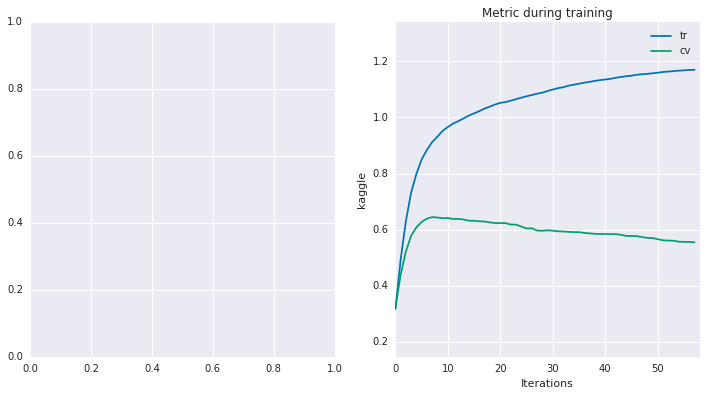

In [72]:
for ds, metrics in evals_result.items():
    for m_name, m_list in metrics.items():
        if m_name=='kaggle':
            for i,m in enumerate(m_list):
                m_list[i] = m % (lgb_kaggle_metric.hack or 1e6)
        else:
            for i,m in enumerate(m_list):
                m_list[i] *= -1
                
canvas(12,6)
fig, (ax0, ax1) = plt.subplots(1,2)
#ax = lgb.plot_metric(evals_result, metric='binary_logloss', ax=ax0);
ax = lgb.plot_metric(evals_result, metric='kaggle', ax=ax1);
canvas(12,12)

0.38608833753644894


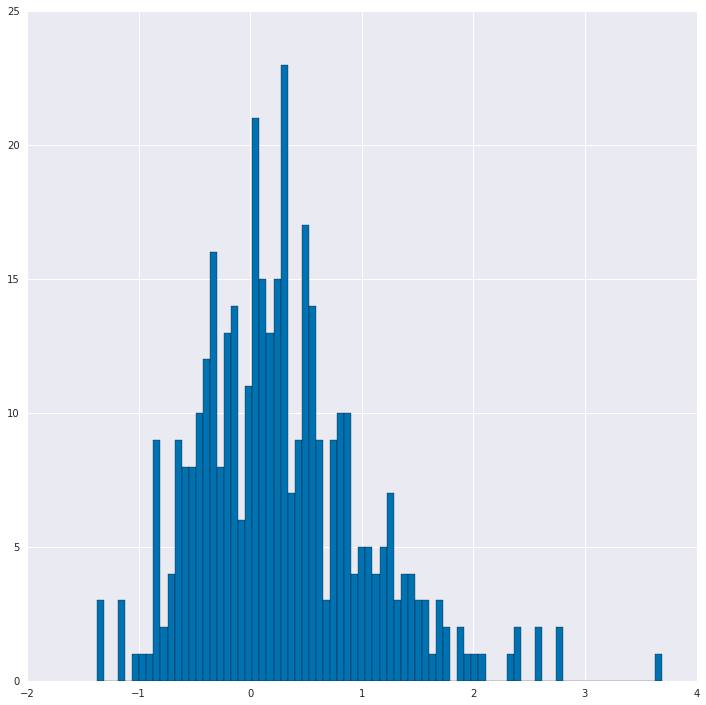

In [73]:
P['guess'] = bst.predict(F_)*2-1
P.guess = P.guess*(np.abs(P.guess)>=0.0)

P['trade'] = P.guess*P.upDown1*P.absVal1

daily = P[ho].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

### ~@~@~@~@~@~@~@~@~@~@~ local analysis of performance ~@~@~@~@~@~@~@~@~@~@~@~

In [ ]:
# buffer zone

In [ ]:
# buff

In [ ]:
# buf it up

In [46]:
#F_.to_pickle('/big/data/play/init9/F_.pkl')
#P.to_pickle('/big/data/play/init9/P.pkl')
F_ = pd.read_pickle('/big/data/play/init9/F_.pkl')
P = pd.read_pickle('/big/data/play/init9/P.pkl')

In [48]:
P['assetCodeId'] = P.assetCode.map(assetCodeIdAssign)

In [74]:
T = P[['time','assetCodeId','trade']].pivot('time','assetCodeId').trade

##### just the stocks with at least ~2000 nonnan days

In [73]:
Tsub = P[cv][['time','assetCodeId','trade']].pivot('time','assetCodeId').trade

In [62]:
xGoodStocks = set(((~T.isna()).sum()>800).nonzero()[0])

0.5804826154730346


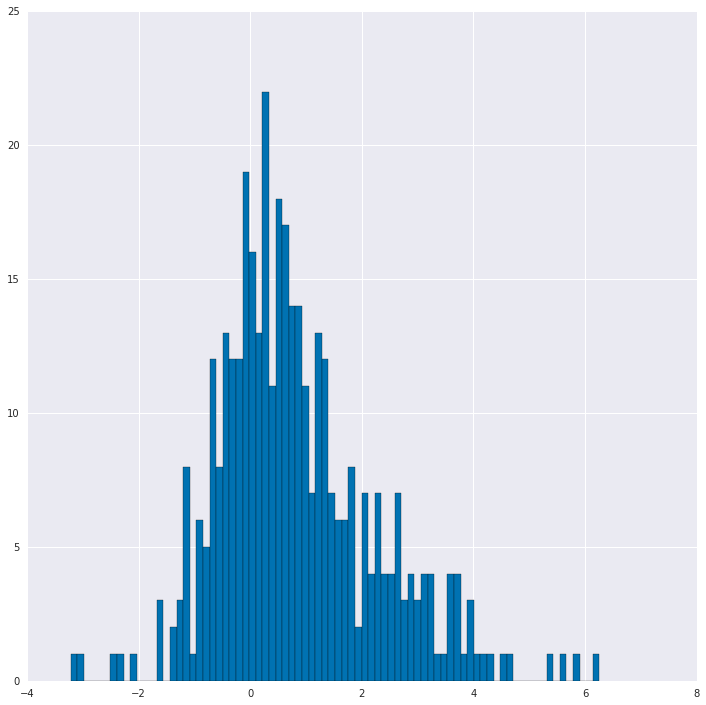

In [92]:
P1 = P.copy()
P1.guess = P1.guess * P1.assetCodeId.isin(xGoodStocks)
P1.guess = P1.guess*(np.abs(P1.guess)>=0.0)

P1['trade'] = P1.guess*P1.upDown1*P1.absVal1

daily = P1[ho].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

##### some correlations idk

In [79]:
tret = Tsub.mean()
tvol = Tsub.std(ddof=0)
tshp = tret/tvol
tnum = (~Tsub.isna()).sum()

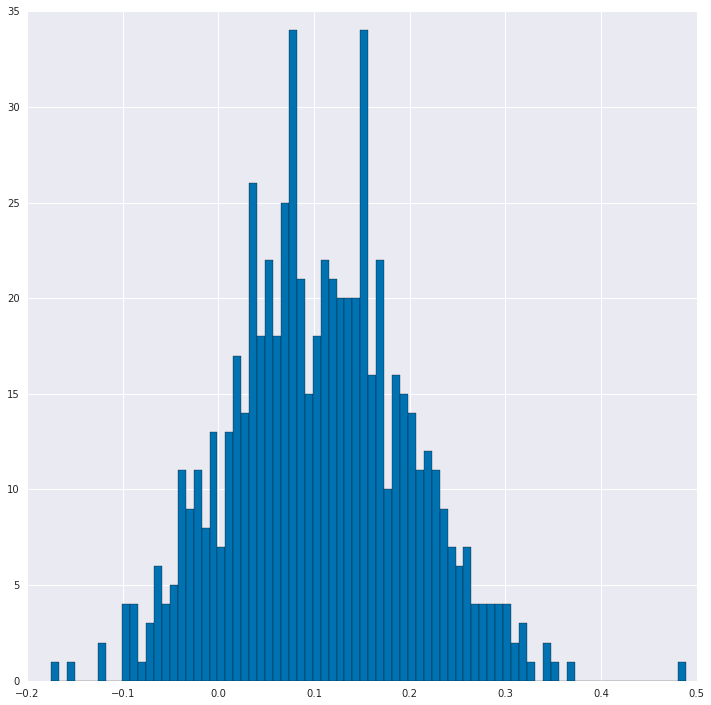

In [78]:
plt.hist(nonnans(tshp[tnum>800]), bins=80);

In [ ]:
Tcorr = T.corr(min_periods=1000)

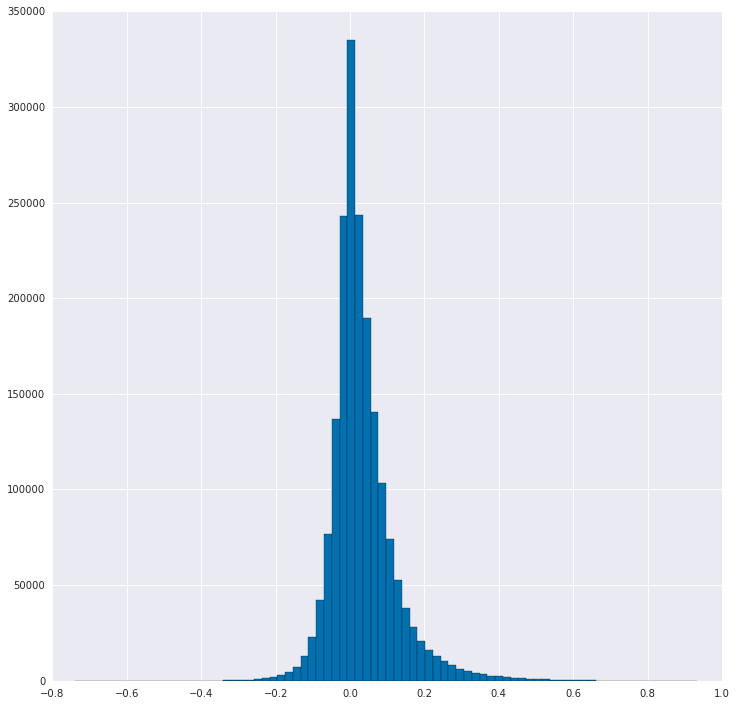

In [85]:
plt.hist(nonnans(offdiag(Tcorr.values)), bins=80);

## +-+-+-+-+-+-+-+-+-+-+-+-+-+-+- Prediction and submission +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

#### define our prdiction function:

In [57]:
def predict(F):
    return bst.predict(F[fSelection]) * 2 - 1

#### the rest of the administrative pipeline

In [66]:
def do_submission_loop():
    feat_iter = iter_features_templates(__env__.get_prediction_days(), U_=(U_,longterm))
    for i, (f, p) in enumerate(feat_iter):
        print_progress(i)
        p.confidenceValue = predict(F=f)
        __env__.predict(p)
        gc.collect()
do_submission_loop()

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630........

In [67]:
__env__.write_submission_file()

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ LOCAL TESTING ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

In [48]:
from common import *

In [49]:
json.dump(list(F.columns), open('feats.json', 'w'))

In [50]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

#### need to make sure feature generation is bug-free

In [84]:
vct = F.nunique()

In [53]:
# reference code to examine column
c = '(oo-aoo)10'
pd.concat([F[c].groupby(P.time).first()], axis=1)
F.m_oo

732812     0.0
732814     0.0
732815     0.0
732816     0.0
732817     0.0
732818     0.0
732819     0.0
732820     0.0
732821     0.0
732822     0.0
732823     0.0
732824     0.0
732825     0.0
732826     0.0
732827     0.0
732828     0.0
732829     0.0
732830     0.0
732831     0.0
732832     0.0
732833     0.0
732834     0.0
732835     0.0
732836     0.0
732837     0.0
732838     0.0
732839     0.0
732840     0.0
732841     0.0
732842     0.0
732843     0.0
732844     0.0
732845     0.0
732848     0.0
732849     0.0
732850     0.0
732851     0.0
732852     0.0
732854     0.0
732855     0.0
732856     0.0
732857     0.0
732858     0.0
732859     0.0
732860     0.0
732863     0.0
732866     0.0
732867     0.0
732868     0.0
732869     0.0
732870     0.0
732871     0.0
732872     0.0
732874     0.0
732875     0.0
732876     0.0
732877     0.0
732878     0.0
732881     0.0
732882     0.0
732883     0.0
732884     0.0
732885     0.0
732886     0.0
732888     0.0
732889     0.0
732890    

In [85]:
vct

assetCodeId                                1098
volume                                    26245
close                                      6444
open                                       6434
assetNameId                                1089
cc                                        24308
oo                                        24153
acc                                       26318
aoo                                       26312
ccTEN                                     25515
ooTEN                                     25339
accTEN                                    26299
aooTEN                                    26296
dayOfYear                                    27
dayOfWeek                                     5
aooTEN1                                   26297
accTEN1                                   26300
ccTEN1                                    25515
oo1                                       24153
cc1                                       24308
acc1                                    

In [74]:
F[F.assetCodeId==3][[c for c in F if 'm_' in c]]

,m_vp5dd1,m_oo1,wVPm_oo1,m_oo5,m_vp5dd5,wVPm_oo5,m_volatility5,wVPm_volatility5,m_oo10,m_vp5dd10,wVPm_oo10,m_volatility10,wVPm_volatility10,m_oo20,m_vp5dd20,wVPm_oo20,m_volatility20,wVPm_volatility20,m_oo60,m_vp5dd60,wVPm_oo60,m_volatility60,wVPm_volatility60
732815,0.173394,0.019632,0.022219,0.041681,-0.332432,0.052502,0.008568,0.009313,0.023750,-0.555924,0.008394,0.011418,0.015948,0.103019,-0.445040,0.134036,0.019660,0.030720,-0.096892,-1.000884,-0.162708,0.030773,0.050675
734404,0.204968,0.015256,0.026705,0.053210,0.091677,0.070977,0.008633,0.011161,0.022924,-0.355954,0.017268,0.011343,0.017076,0.097369,-0.266120,0.125582,0.019492,0.030382,-0.025955,-0.867409,-0.021370,0.029882,0.048662
735994,0.142907,0.012129,0.021354,0.059879,0.460591,0.085483,0.008335,0.010752,0.045862,-0.271356,0.063358,0.010881,0.015455,0.131284,-0.254814,0.173245,0.018791,0.029592,-0.032214,-0.746210,-0.050856,0.029832,0.048290
737587,0.084363,-0.001294,-0.011939,0.063540,0.625241,0.077366,0.007227,0.013931,0.042869,-0.179688,0.053502,0.010999,0.016254,0.073933,-0.201149,0.072437,0.015373,0.023449,0.051924,-0.733448,0.090561,0.027832,0.044054
739182,0.021298,-0.016981,-0.023628,0.028882,0.626930,0.034712,0.013342,0.020604,0.039686,-0.058569,0.050151,0.011541,0.016804,0.048184,-0.193313,0.043606,0.016003,0.024182,-0.027488,-0.675133,-0.037108,0.026647,0.042090
740777,0.036920,0.009784,0.014293,0.019050,0.490456,0.026785,0.011783,0.019651,0.061388,0.158024,0.079288,0.010549,0.015590,0.054259,-0.139516,0.052481,0.016079,0.024318,-0.075994,-0.660284,-0.131572,0.025465,0.039667
742373,-0.012691,-0.020432,-0.033144,-0.017133,0.272797,-0.033064,0.013371,0.021171,0.035923,0.364474,0.037913,0.013229,0.019865,0.029067,-0.154874,0.016407,0.016860,0.025536,-0.052219,-0.632187,-0.088707,0.024949,0.038705
743970,-0.031583,-0.021246,-0.036232,-0.049694,0.098306,-0.090651,0.012257,0.018292,0.007457,0.558897,-0.005167,0.015122,0.023137,0.045348,-0.155217,0.040394,0.015329,0.023087,-0.027934,-0.656757,-0.054739,0.024430,0.037936
745564,0.005184,-0.005069,-0.012900,-0.053182,0.019127,-0.091611,0.011804,0.018230,0.006647,0.644368,-0.014245,0.015153,0.023425,0.004227,-0.079513,-0.022249,0.013311,0.020505,-0.034508,-0.553725,-0.069641,0.024437,0.037965
747159,0.059852,-0.015480,-0.022051,-0.051753,0.057681,-0.090035,0.011661,0.018149,-0.024675,0.684611,-0.055323,0.014930,0.023078,-0.001370,-0.029676,-0.035248,0.013591,0.020947,-0.075164,-0.441923,-0.135170,0.024254,0.037606


In [150]:
BUG.V_.m_oo[-5:]

array([ 0.01469621,  0.01152872, -0.00175254, -0.01747028,  0.00641909])

#### something else too lazy to comment

In [73]:
test = pd.read_pickle('../data/given/test.pkl')

In [74]:
X = pd.concat([day[0][['time','assetCode','returnsOpenPrevMktres10']] for day in test], axis=0)
X.reset_index(drop=True, inplace=True)

In [75]:
#Z = pd.concat([day[2] for day in test], axis=0)
#Z.reset_index(drop=True, inplace=True)

In [76]:
# all this cell just to make the target column

times = X.time.unique()
times10 = np.shift(times, -10)
times10map = dict(zip(times,times10))

Y = X.copy()
Y.time = X.time.map(times10map)
next10index = Y[~Y.time.isna()].set_index(['time','assetCode']).index

_ans = X.set_index(['time','assetCode']).loc[next10index].returnsOpenPrevMktres10.values
_ans = np.pad(_ans, pad_width=(0,len(X)-len(_ans)), mode='constant', constant_values=0.)
X['answer'] = _ans

In [77]:
X['guess'] = __env__._submission.confidenceValue.values * 2 - 1

In [78]:
X['universe'] = (~X.answer.isna()) & (np.abs(X.answer) < 2)

#X.answer = Z.returnsOpenNextMktres10.values
#X.universe = Z.universe.values

X['target'] = X.answer > 0
X['upDown'] = X.target * 2 - 1
X['upDown1'] = X.upDown * X.universe.astype(int)
X['absVal'] = np.abs(X.answer)
X['absVal1'] = X.absVal * X.universe
X['weight'] = X.absVal#.qtl()
X['weight1'] = X.weight * X.universe

In [79]:
X['trade'] = X.guess*X.upDown1*X.absVal1

0.10556716614607231


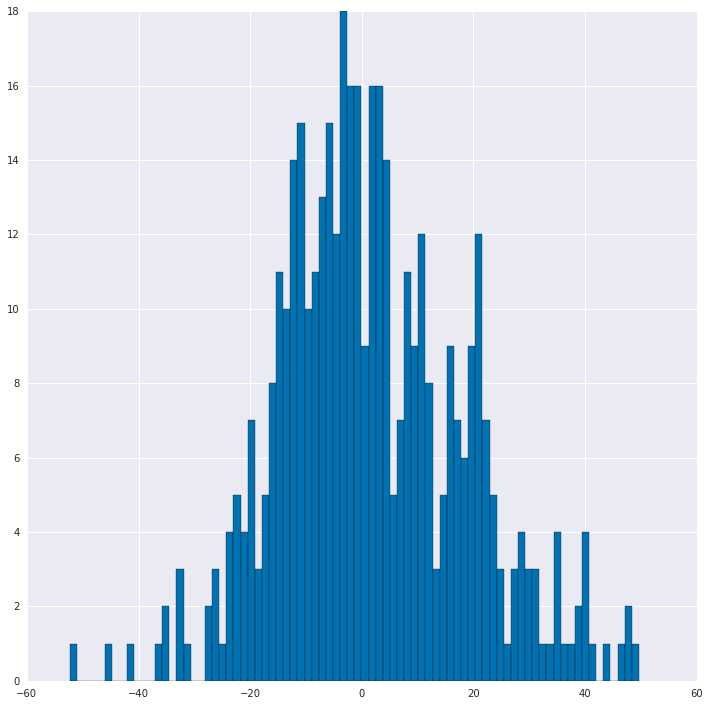

In [80]:
lb = X.time < '2018-09-01'
daily = X[lb].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

# --------------------------------------- SCRATCH ----------------------------------------------------

In [65]:
F0['(oo0-cc0)'] = F0['(it,af,it{1},oo0,cc0){3/4}']

In [66]:
F0.drop(columns=[c for c in F0.columns if c not in fNewnewfault], inplace=True)

In [69]:
gc.collect()
df = F[F0.columns]
df0 = F0
eq = np.abs(df0.fillna(np.inf)-df.fillna(np.inf)).fillna(0)<1e-8

In [70]:
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
eq.sum(axis=0)/len(eq)

volume                      1.000000
close                       1.000000
open                        1.000000
assetCodeId                 1.000000
assetNameId                 1.000000
cc                          1.000000
oo                          1.000000
cc0                         1.000000
oo0                         1.000000
cc_10                       1.000000
oo_10                       1.000000
cc0_10                      1.000000
oo0_10                      1.000000
dayOfYear                   1.000000
dayOfWeek                   1.000000
ooSince21                   1.000000
ooMaxSince21                1.000000
ooDrawdownSince21           1.000000
ooMinSince21                1.000000
ooSince62                   1.000000
ooMaxSince62                1.000000
ooDrawdownSince62           1.000000
ooMinSince62                1.000000
ooSince125                  1.000000
ooMaxSince125               1.000000
ooDrawdownSince125          1.000000
ooMinSince125               1.000000
o

In [57]:
dude = M[M.assetCode=='AAPL.O'][M.time<'2009-01-03'].tail(5)
set_basic_features(M=dude)
dude

,time,assetCode,assetName,volume,close,open,returnsOpenNextMktres10,universe,assetCodeId,assetNameId,cc,oo,cc0,oo0,cc_10,oo_10,cc0_10,oo0_10,dayOfYear,dayOfWeek
726443,2008-12-26 22:00:00+00:00,AAPL.O,Apple Inc,11043071.0,85.81,86.55,0.023792,1.0,3,3,0.009014,0.005213,0.005038,0.001207,-0.101741,-0.115534,-0.100484,-0.078656,361.0,4.0
728035,2008-12-29 22:00:00+00:00,AAPL.O,Apple Inc,24567225.0,86.61,86.62,-0.008313,1.0,3,3,0.009280,0.000808,0.011972,-0.001201,-0.126304,-0.069885,-0.109256,-0.070672,364.0,0.0
729627,2008-12-30 22:00:00+00:00,AAPL.O,Apple Inc,34579620.0,86.29,87.42,0.008330,1.0,3,3,-0.003702,0.009193,-0.020864,0.010283,-0.093528,-0.093416,-0.130348,-0.078830,365.0,1.0
731221,2008-12-31 22:00:00+00:00,AAPL.O,Apple Inc,21715763.0,85.35,86.00,0.052227,1.0,3,3,-0.010953,-0.016377,-0.023658,-0.028226,-0.111633,-0.088947,-0.093581,-0.116575,366.0,2.0
732815,2009-01-02 22:00:00+00:00,AAPL.O,Apple Inc,26964210.0,90.75,85.58,-0.026166,1.0,3,3,0.061348,-0.004896,0.032733,-0.015290,0.017676,-0.061408,-0.029549,-0.053305,2.0,4.0


In [58]:
dude.oo.sum()

-0.0060578004450126009

In [63]:
c = '(oo0-cc0)'
guy = pd.concat({'time':P.time,'assetCodeId':F.assetCodeId,'df':df[c],'df0': df0[c],'cc0':df.cc0,'oo0':df.oo0}, axis=1)
guy[(guy.assetCodeId!=-1) & (df[c]!=df0[c])].pipe(lambda x: pd.concat([x, x.oo0-x.cc0], axis=1))

,assetCodeId,cc0,df,df0,oo0,time,0
732812,0,0.028696,1.256251e-02,-0.064784,4.125897e-02,2009-01-02 22:00:00+00:00,1.256251e-02
732813,1,-0.018934,-3.017972e-02,0.042388,-4.911375e-02,2009-01-02 22:00:00+00:00,-3.017972e-02
732814,2,-0.010750,1.986397e-02,0.021261,9.114077e-03,2009-01-02 22:00:00+00:00,1.986397e-02
732815,3,0.032733,-4.802233e-02,-0.004568,-1.528981e-02,2009-01-02 22:00:00+00:00,-4.802233e-02
732816,1564,-0.055761,1.097132e-01,0.002326,5.395219e-02,2009-01-02 22:00:00+00:00,1.097132e-01
732817,4,-0.017254,3.152896e-02,-0.011766,1.427474e-02,2009-01-02 22:00:00+00:00,3.152896e-02
732818,5,-0.017041,3.983991e-02,0.004516,2.279893e-02,2009-01-02 22:00:00+00:00,3.983991e-02
732819,7,-0.045668,4.680588e-02,-0.029059,1.138005e-03,2009-01-02 22:00:00+00:00,4.680588e-02
732820,2099,-0.042891,9.170951e-02,-0.053478,4.881807e-02,2009-01-02 22:00:00+00:00,9.170951e-02
732821,8,-0.008815,7.970818e-03,0.010375,-8.440820e-04,2009-01-02 22:00:00+00:00,7.970818e-03


In [58]:
for c in combos.omo(5):
    name = '(it,af,it{{1}},oo0,cc0){{{}}}'.format(combos.name.index(c))
    if name == '(it,af,it{1},oo0,cc0){3/4}':
        print(c)
        print(c@np.asarray([[0]*9,[1]*9,[2]*9,[4]*9,[8.]*9]))

[ 0  0  0  1 -1]
[-4. -4. -4. -4. -4. -4. -4. -4. -4.]
